In [1]:
pwd

'C:\\Users\\Baron\\Desktop\\EE_297_Repo\\EE_297\\ML_PATH_EE297\\EE297_env\\01_main\\04_multitask'

In [2]:
pwd

'C:\\Users\\Baron\\Desktop\\EE_297_Repo\\EE_297\\ML_PATH_EE297\\EE297_env\\01_main\\04_multitask'

In [3]:
pwd

'C:\\Users\\Baron\\Desktop\\EE_297_Repo\\EE_297\\ML_PATH_EE297\\EE297_env\\01_main\\04_multitask'

In [4]:
# --- Pretrained YOLOv5 object detection on a folder of images ---
# Works with torch.hub (Ultralytics YOLOv5). No training required.

#1. Import Necessary Liobraries
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import cv2
import random
import shutil
from tqdm.auto import tqdm as notebook_tqdm
import tqdm
import tensorflow as tf

import pandas as pd
import numpy as np
from PIL import Image

import os

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt


from keras.models import Sequential
from keras.layers import Input, AveragePooling2D, Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.regularizers import l1

from keras.optimizers import Adam
from sklearn.model_selection import learning_curve
from sklearn.model_selection import StratifiedKFold
from sklearn.utils import shuffle

from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from tensorflow.keras.losses import SparseCategoricalCrossentropy

import seaborn as sns

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

#import torchvision.transforms as transforms

#import warnings
#warnings.filterwarnings("ignore")


### Loading the dataset

In [5]:
IMAGE_FOLDER = r"Z:\EE_297A\dataset\lanes\images"
MASK_FOLDER = r"Z:\EE_297A\dataset\lanes\masks"

In [6]:
def create_dirs_if_not_exist(path):
    if not os.path.exists(path):
        os.makedirs(path)
        print("Directory created:", path)
    else:
        print("Directory already exists:", path)

In [7]:
create_dirs_if_not_exist(IMAGE_FOLDER)
create_dirs_if_not_exist(MASK_FOLDER)

Directory already exists: Z:\EE_297A\dataset\lanes\images
Directory already exists: Z:\EE_297A\dataset\lanes\masks


In [8]:
### Copy Images to  the Directory:
"""
This code is a data pre-processing script that goes through the TuSimple dataset’s
train_set/clips directory and copies only the 20th frame of each video clip into a single
flat folder — typically to simplify training or dataset access.
"""

CLIPS_PATH = r"Z:\EE_297A\dataset\lanes\TUSimple\train_set\clips"

# iterate through each directory
for clip_dir in os.listdir(CLIPS_PATH):
    clip_dir_path = os.path.join(CLIPS_PATH, clip_dir)

    print("Processing Clip:", clip_dir)
    # iterate through each sub directory
    for frame_dir in os.listdir(clip_dir_path):
        frame_path = os.path.join(clip_dir_path, frame_dir, "20.jpg")

        # check if file is present
        if not os.path.isfile(frame_path):
            continue

        # create new filename based on last 2 directory names
        clip_name = os.path.basename(os.path.dirname(frame_path))
        date_name = os.path.basename(os.path.dirname(os.path.dirname(frame_path)))
        new_filename = f"{date_name}_{clip_name}.jpg"
        new_file_path = os.path.join(IMAGE_FOLDER, new_filename)

        # copy the file
        shutil.copy(frame_path, new_file_path)


Processing Clip: 0313-1
Processing Clip: 0313-2
Processing Clip: 0531
Processing Clip: 0601


In [9]:
print("Total images in dataset:", len(os.listdir(IMAGE_FOLDER)))

Total images in dataset: 3626


In [10]:
# load the dataset json files
"""
Code Purpose: Load and combine TuSimple lane label JSONs
lines=True tells pandas each line is a separate JSON object (which is true for TuSimple).
Each line describes a labeled frame's lanes + metadata.
"""

df1_313 = pd.read_json(r"Z:\EE_297A\dataset\lanes\TUSimple\train_set\label_data_0313.json", lines = True)
df2_531 = pd.read_json(r"Z:\EE_297A\dataset\lanes\TUSimple\train_set\label_data_0531.json", lines = True)
df3_601 = pd.read_json(r"Z:\EE_297A\dataset\lanes\TUSimple\train_set\label_data_0601.json", lines = True)

# combine into single dataframe
df_json = pd.concat([df1_313, df2_531, df3_601])
df_json.head()

lanes  \
0  [[-2, -2, -2, -2, 632, 625, 617, 609, 601, 594...   
1  [[-2, -2, -2, 658, 646, 635, 623, 612, 601, 58...   
2  [[-2, 570, 554, 538, 522, 505, 489, 473, 456, ...   
3  [[-2, -2, -2, -2, 555, 542, 530, 517, 505, 493...   
4  [[-2, -2, -2, 522, 525, 528, 531, 534, 537, 53...   

                                           h_samples  \
0  [240, 250, 260, 270, 280, 290, 300, 310, 320, ...   
1  [240, 250, 260, 270, 280, 290, 300, 310, 320, ...   
2  [240, 250, 260, 270, 280, 290, 300, 310, 320, ...   
3  [240, 250, 260, 270, 280, 290, 300, 310, 320, ...   
4  [240, 250, 260, 270, 280, 290, 300, 310, 320, ...   

                    raw_file  
0   clips/0313-1/6040/20.jpg  
1   clips/0313-1/5320/20.jpg  
2  clips/0313-1/23700/20.jpg  
3  clips/0313-1/51660/20.jpg  
4  clips/0313-1/25680/20.jpg

### Creating the Masks
1. What is a mask?
Mask: Creating a binary image (also called a segmentation mask) that marks the lane locations pixel-by-pixel.
2. Creating a binary image (also called a segmentation mask) that marks the lane locations pixel-by-pixel.

In [11]:
# create function for generating masks
def generate_lane_mask(row):
    # create a mask of all zeros
    mask = np.zeros((728, 1280, 1), dtype=np.uint8)

    # extract data from the row
    h_samples = row.h_samples
    lanes = row.lanes
    raw_file = row.raw_file

    # create mask: lane = 1, non-lane = 0
    for lane in lanes:
        # exclude -2 datapoints
        h_samples_filtered = [y for x, y in zip(lane, h_samples) if x != -2]
        lane_filtered = [x for x in lane if x != -2]

        # create array of lane points
        lane_points = np.array(list(zip(lane_filtered, h_samples_filtered)))

        # update lane mask
        cv2.polylines(mask, [lane_points], isClosed = False, color = (255, 255, 255), thickness = 15)
    
    # generate mask filename
    raw_file_path = os.path.normpath(raw_file)  # handles / vs \ properly
    clip_name = os.path.basename(os.path.dirname(raw_file_path))     # e.g., 5160
    date_name = os.path.basename(os.path.dirname(os.path.dirname(raw_file_path)))  # e.g., 0313-1
    mask_filename = f"{date_name}_{clip_name}.jpg"
    mask_filename_path = os.path.join(MASK_FOLDER, mask_filename)

    # write the mask image
    cv2.imwrite(mask_filename_path, mask)

In [12]:
# generate masks
from tqdm import tqdm  # ✅ Ensure this import is present

for index, row in tqdm(df_json.iterrows(), total=len(df_json)):
    generate_lane_mask(row)

100%|█████████████████████████████████████████████████████████████████████████████| 3626/3626 [00:09<00:00, 368.29it/s]


In [13]:
def visualize_image(image_name):
    # get paths
    image_path = os.path.join(IMAGE_FOLDER, image_name)
    mask_path = os.path.join(MASK_FOLDER, image_name)
    
    # read the image and mask
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    mask = cv2.imread(mask_path)
    
    # plot the image
    plt.figure(figsize = (20, 8))
    plt.subplot(1, 2, 1)
    plt.imshow(image)
    plt.title("Road Image")

    plt.subplot(1, 2, 2)
    plt.imshow(mask, cmap="gray")
    plt.title("Ground Truth Mask")
    
    # show the images
    plt.show()

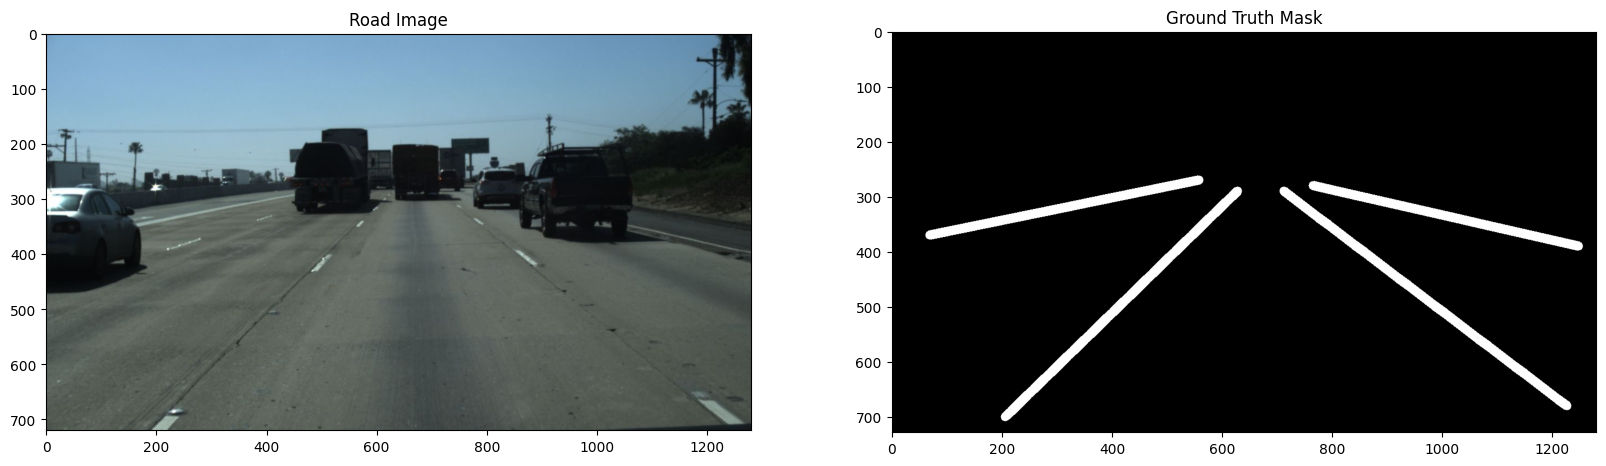

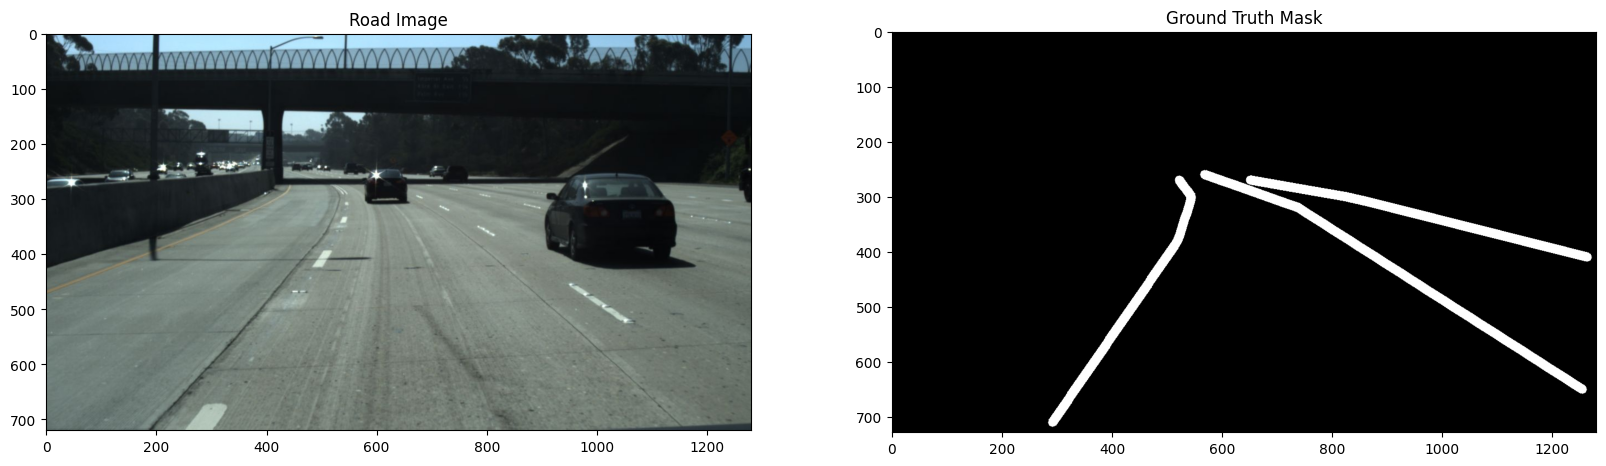

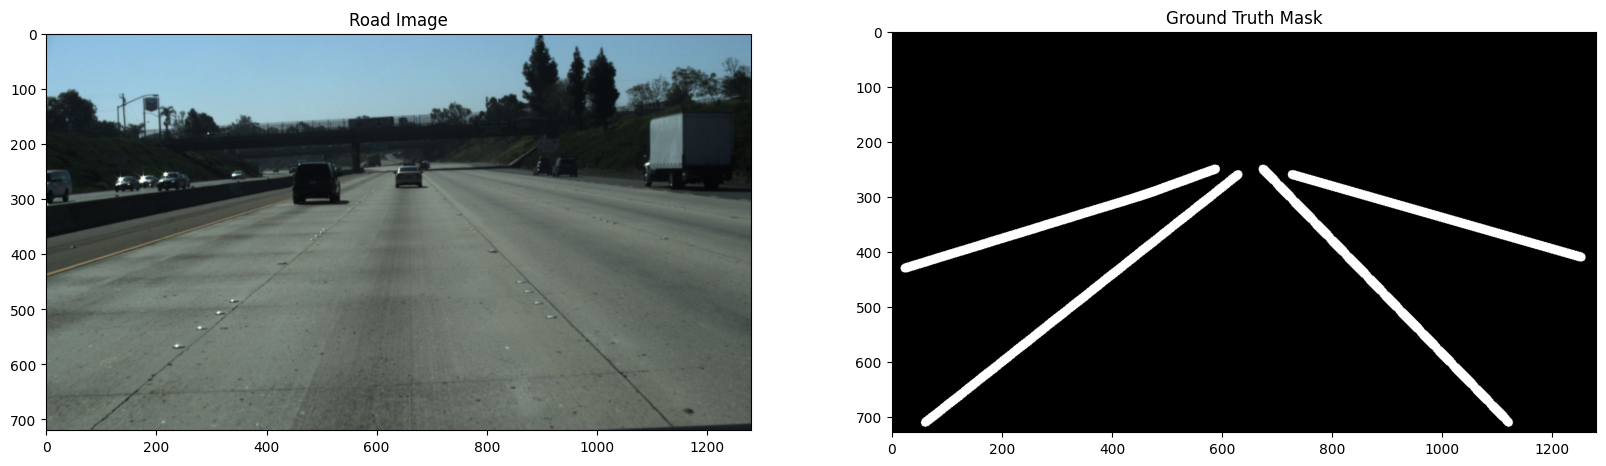

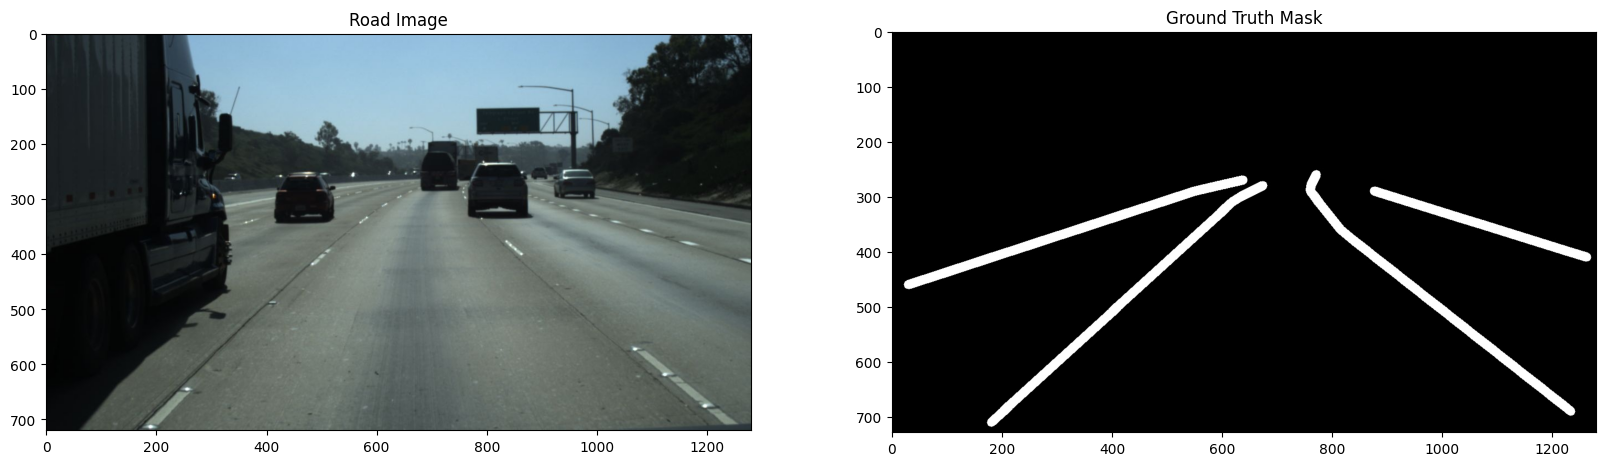

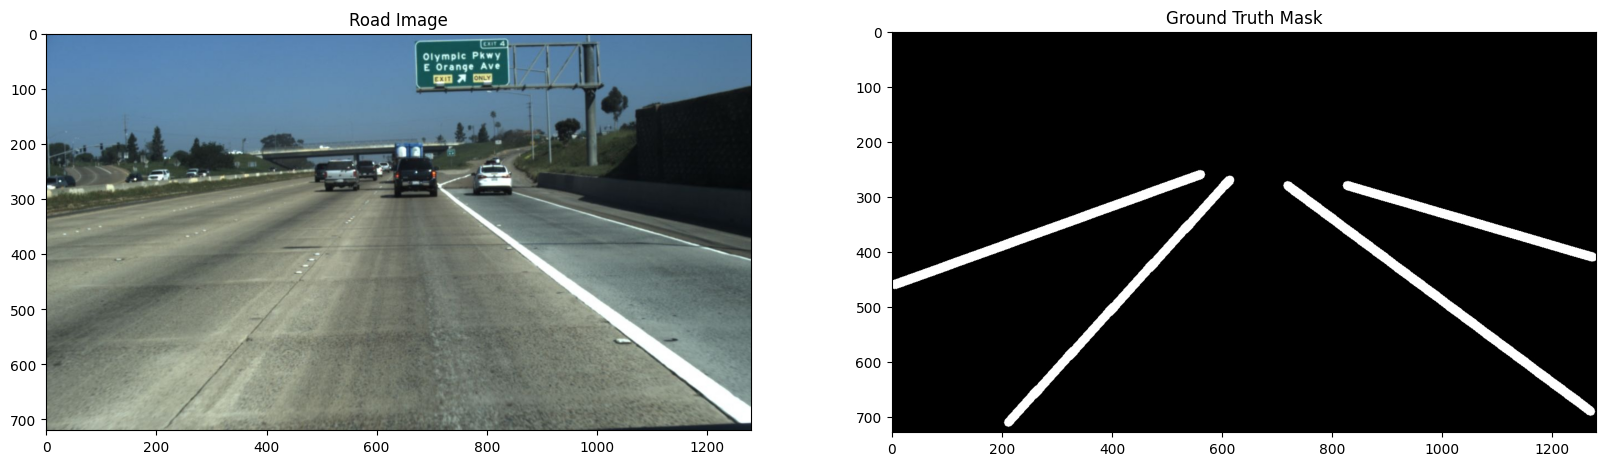

In [14]:
for i in range(5):
    image_name = random.choice(os.listdir(IMAGE_FOLDER))
    visualize_image(image_name)

### Training and Testing Splits and Processing
    1. Images
    2. Masks 

In [15]:
lane_train_image_folder = r"Z:\EE_297A\dataset\lanes\train\images"
lane_test_image_folder = r"Z:\EE_297A\dataset\lanes\test\images"
lane_train_mask_folder = r"Z:\EE_297A\dataset\lanes\train\masks"
lane_test_mask_folder = r"Z:\EE_297A\dataset\lanes\test\masks"

In [16]:
for folder_path in [lane_train_image_folder, lane_test_image_folder, lane_train_mask_folder, lane_test_mask_folder]:
    create_dirs_if_not_exist(folder_path)

Directory already exists: Z:\EE_297A\dataset\lanes\train\images
Directory already exists: Z:\EE_297A\dataset\lanes\test\images
Directory already exists: Z:\EE_297A\dataset\lanes\train\masks
Directory already exists: Z:\EE_297A\dataset\lanes\test\masks


In [17]:
from sklearn.model_selection import train_test_split
images = [file for file in os.listdir(IMAGE_FOLDER) if file.endswith(".jpg")]
masks = [file for file in os.listdir(MASK_FOLDER) if file.endswith(".jpg")]

# split for train and test
lane_train_images, lane_val_images = train_test_split(images, test_size=0.1, random_state=42)

### Feature Engineering
    What is feature engineering:
    Feature engineering is the process of creating, transforming, or selecting input variables (features) from raw data in order to improve the performance of a machine learning model.

    1. Image Loading and Preprocessing
    2. Image Sharpening Using a Convolution Kernel
    3. Mask Loading and Normalization
    4.

In [18]:
import tensorflow as tf

def load_image(image_path, mask_path):
    size = [224, 224]

    # 1. Image Loading and Preprocessing
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, size)
    image = image / 255.0  

    # 2. Image Sharpening Using a Convolution Kernel
    kernel = tf.constant([[0., -1., 0.],
                          [-1., 5., -1.],
                          [0., -1., 0.]], dtype=tf.float32)
    kernel = tf.reshape(kernel, [3, 3, 1, 1])

    channels = tf.split(image, num_or_size_splits=3, axis=-1)
    sharpened_channels = []
    for c in channels:
        c_sharp = tf.nn.conv2d(tf.expand_dims(c, axis=0), kernel, strides=1, padding="SAME")
        sharpened_channels.append(tf.squeeze(c_sharp, axis=0))
    image = tf.concat(sharpened_channels, axis=-1)
    image = tf.clip_by_value(image, 0.0, 1.0)  

   # 3. Mask Loading and Normalization
    mask = tf.io.read_file(mask_path)
    mask = tf.image.decode_jpeg(mask, channels=1)
    mask = tf.image.resize(mask, size)
    mask = mask / 255.0  
    
    return image, mask

In [19]:
def dataset_from_folder(image_folder, mask_folder):
    image_files = sorted([os.path.join(image_folder, file) for file in os.listdir(image_folder) if file.endswith(".jpg")])
    mask_files = sorted([os.path.join(mask_folder, file) for file in os.listdir(mask_folder) if file.endswith(".jpg")])

    dataset = tf.data.Dataset.from_tensor_slices((image_files, mask_files))
    dataset = dataset.map(lambda image_path, mask_path: load_image(image_path, mask_path))
    
    return dataset


In [20]:
# load dataset from folder
lane_train_dataset = dataset_from_folder(lane_train_image_folder, lane_train_mask_folder)
lane_test_dataset = dataset_from_folder(lane_test_image_folder, lane_test_mask_folder)

### YOLOv5 Pretrained Model

In [21]:
# === YOLOv5 one-image test from TuSimple-style dataframe ===
# df_json columns: ["lanes", "h_samples", "raw_file"] where raw_file is like "clips/.../img.jpg"

import os
from pathlib import Path
import torch
import pandas as pd
from PIL import Image, ImageDraw, ImageFont

In [22]:
# Cache model so it loads once
_YOLO = None

COCO_NAMES = [
    'person','bicycle','car','motorcycle','airplane','bus','train','truck','boat',
    'traffic light','fire hydrant','stop sign','parking meter','bench','bird','cat','dog','horse',
    'sheep','cow','elephant','bear','zebra','giraffe','backpack','umbrella','handbag','tie','suitcase',
    'frisbee','skis','snowboard','sports ball','kite','baseball bat','baseball glove','skateboard',
    'surfboard','tennis racket','bottle','wine glass','cup','fork','knife','spoon','bowl','banana',
    'apple','sandwich','orange','broccoli','carrot','hot dog','pizza','donut','cake','chair','couch',
    'potted plant','bed','dining table','toilet','tv','laptop','mouse','remote','keyboard','cell phone',
    'microwave','oven','toaster','sink','refrigerator','book','clock','vase','scissors','teddy bear',
    'hair drier','toothbrush'
]
VEHICLE_SET = {'car','bus','truck','motorcycle','bicycle'}

In [24]:
def _draw_boxes(img_path, df_boxes, out_path):
    im = Image.open(img_path).convert("RGB")
    draw = ImageDraw.Draw(im)
    try:
        font = ImageFont.load_default()
    except:
        font = None

    for _, r in df_boxes.iterrows():
        x1, y1, x2, y2 = map(float, [r["xmin"], r["ymin"], r["xmax"], r["ymax"]])
        label = f'{r["name"]} {r["confidence"]:.2f}'
        draw.rectangle([(x1, y1), (x2, y2)], outline=(0, 255, 0), width=2)
        # text box
        try:
            tw, th = draw.textlength(label, font=font), (font.getbbox(label)[3] if font else 12)
        except:
            tw, th = draw.textsize(label, font=font)
        draw.rectangle([(x1, y1 - th - 2), (x1 + tw + 4, y1)], fill=(0, 255, 0))
        draw.text((x1 + 2, y1 - th - 1), label, fill=(0, 0, 0), font=font)

    Path(out_path).parent.mkdir(parents=True, exist_ok=True)
    im.save(out_path)
    return out_path

In [25]:
def run_pretrained_yolo_on_index(
    df: pd.DataFrame,
    idx: int,
    dataset_root: str,
    output_dir: str = "./yolo_pretrained_out",
    vehicles_only: bool = True,
    yolo_variant: str = "yolov5s",
    img_size: int = 640,
    conf_thres: float = 0.25,
    iou_thres: float = 0.45,
):
    """
    df:      your dataframe (must have 'raw_file' column)
    idx:     which row to use
    dataset_root: folder that contains 'clips/' (e.g., r'Z:\\EE_297A\\dataset\\lanes\\TUSimple\\train_set')
    """
    assert "raw_file" in df.columns, "DataFrame must include a 'raw_file' column."
    assert 0 <= idx < len(df), f"idx out of range (0..{len(df)-1})"

    img_rel = str(df.iloc[idx]["raw_file"])          # e.g. 'clips/0313-1/6040/20.jpg'
    img_path = str(Path(dataset_root) / Path(img_rel))
    if not os.path.isfile(img_path):
        raise FileNotFoundError(f"Image not found: {img_path}")

    model = _load_yolo(yolo_variant, conf=conf_thres, iou=iou_thres)

    with torch.inference_mode():
        results = model([img_path], size=img_size)

    det_df = results.pandas().xyxy[0].copy()
    det_df["image_path"] = img_path

    if vehicles_only:
        det_df = det_df[det_df["name"].isin(VEHICLE_SET)].reset_index(drop=True)

    # Save outputs
    stem = Path(img_path).stem
    vis_path = str(Path(output_dir) / "vis" / f"{stem}_det.png")
    csv_path = str(Path(output_dir) / "csv" / f"{stem}_det.csv")

    if len(det_df):
        _draw_boxes(img_path, det_df, vis_path)
    else:
        Path(Path(vis_path).parent).mkdir(parents=True, exist_ok=True)
        Image.open(img_path).convert("RGB").save(vis_path)

    Path(Path(csv_path).parent).mkdir(parents=True, exist_ok=True)
    det_df.to_csv(csv_path, index=False)

    print(f"[YOLO] idx={idx}  file={img_rel}")
    print(f"[YOLO] detections={len(det_df)}  saved vis -> {vis_path}")
    print(f"[YOLO] csv -> {csv_path}")
    return det_df, vis_path

In [26]:
DATASET_ROOT = r"Z:\EE_297A\dataset\lanes\TUSimple\train_set"  # folder that contains 'clips'
# Pick any row index you want to test:
det_df, vis_path = run_pretrained_yolo_on_index(
    df=df_json,
    idx=0,                               # change this to test any image
    dataset_root=DATASET_ROOT,
    output_dir="./yolo_pretrained_out",
    vehicles_only=True                   # set False to see all 80 COCO classes
)
det_df.head()

WARNING torchvision==0.20 is incompatible with torch==2.4.
Run 'pip install torchvision==0.19' to fix torchvision or 'pip install -U torch torchvision' to update both.
For a full compatibility table see https://github.com/pytorch/vision#installation


Using cache found in C:\Users\Baron/.cache\torch\hub\ultralytics_yolov5_master
YOLOv5  2025-8-13 Python-3.8.20 torch-2.4.1 CUDA:0 (NVIDIA GeForce RTX 3060 Ti, 8191MiB)

Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients, 16.4 GFLOPs
Adding AutoShape... 
C:\Users\Baron/.cache\torch\hub\ultralytics_yolov5_master\models\common.py:906: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


[YOLO] Loaded yolov5s on cuda
[YOLO] idx=0  file=clips/0313-1/6040/20.jpg
[YOLO] detections=8  saved vis -> yolo_pretrained_out\vis\20_det.png
[YOLO] csv -> yolo_pretrained_out\csv\20_det.csv


xmin        ymin         xmax        ymax  confidence  class   name  \
0  1002.730469  250.029114  1137.040283  332.461426    0.872122      2    car   
1   146.230347  236.684631   329.157532  369.757996    0.834090      2    car   
2   452.523987  242.931274   565.786316  340.232483    0.811248      2    car   
3  1156.653320    7.601379  1278.688232  524.300598    0.553368      7  truck   
4   108.500633  269.073181   155.917755  298.257263    0.550516      2    car   

                                          image_path  
0  Z:\EE_297A\dataset\lanes\TUSimple\train_set\cl...  
1  Z:\EE_297A\dataset\lanes\TUSimple\train_set\cl...  
2  Z:\EE_297A\dataset\lanes\TUSimple\train_set\cl...  
3  Z:\EE_297A\dataset\lanes\TUSimple\train_set\cl...  
4  Z:\EE_297A\dataset\lanes\TUSimple\train_set\cl...

Using cache found in C:\Users\Baron/.cache\torch\hub\ultralytics_yolov5_master
YOLOv5  2025-8-13 Python-3.8.20 torch-2.4.1 CUDA:0 (NVIDIA GeForce RTX 3060 Ti, 8191MiB)

Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients, 16.4 GFLOPs
Adding AutoShape... 


[YOLO] yolov5s loaded on cuda


C:\Users\Baron/.cache\torch\hub\ultralytics_yolov5_master\models\common.py:906: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


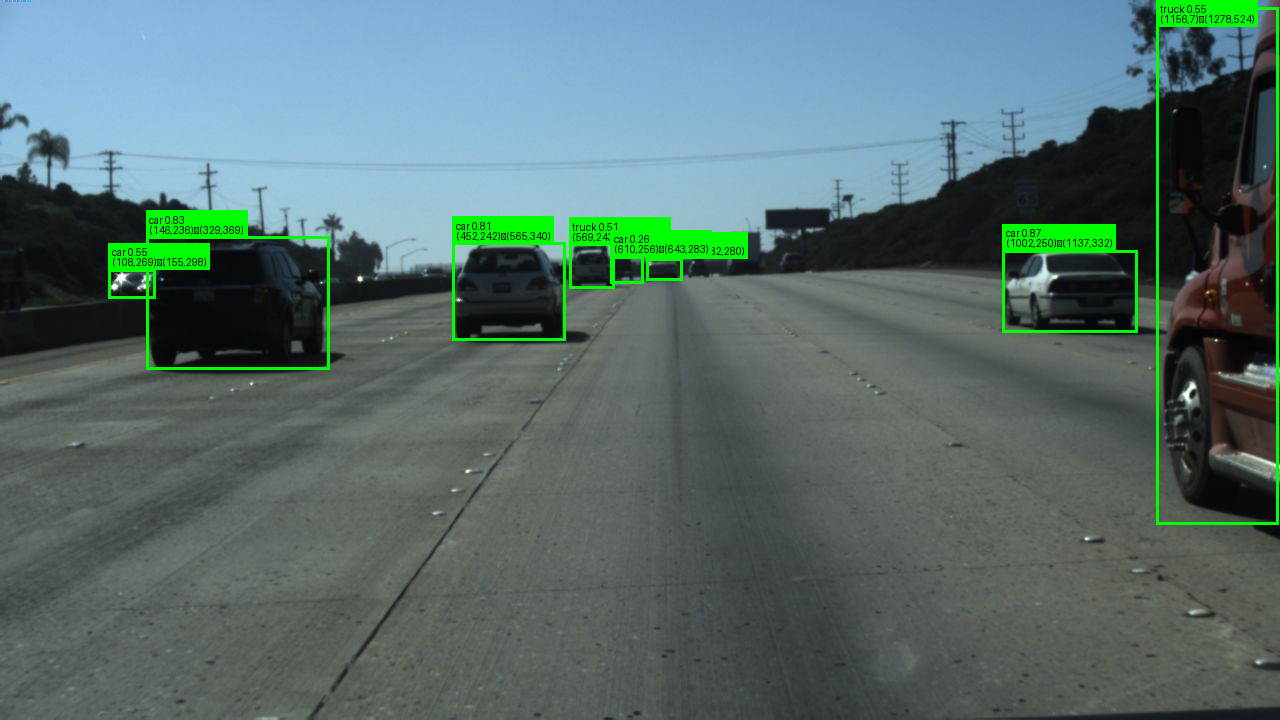

In [28]:
DATASET_ROOT = r"Z:\EE_297A\dataset\lanes\TUSimple\train_set"  # folder that contains 'clips'
show_yolo_on_df_index(
    df=df_json,
    idx=0,                 # change this index to test any frame
    dataset_root=DATASET_ROOT,
    vehicles_only=True,    # set False to draw all COCO classes
    save=False
)

In [29]:
def show_yolo_on_df_index(
    df,
    idx: int,
    dataset_root: str,
    vehicles_only: bool = True,
    img_size: int = 640,
    yolo_variant: str = "yolov5s",
    conf_thres: float = 0.25,
    iou_thres: float = 0.45,
    save: bool = False,
    out_dir: str = "./yolo_vis"
):
    # Build absolute image path from df['raw_file']
    img_rel = str(df.iloc[idx]["raw_file"])
    img_path = str(Path(dataset_root) / img_rel)
    if not Path(img_path).is_file():
        raise FileNotFoundError(f"Image not found: {img_path}")

    model = _load_yolo(yolo_variant, conf_thres, iou_thres)

    # Run inference
    with torch.inference_mode():
        results = model([img_path], size=img_size)

    # Open image
    im = Image.open(img_path).convert("RGB")
    width, height = im.size
    print(f"Image resolution: {width} x {height} pixels")

    draw = ImageDraw.Draw(im)
    try:
        font = ImageFont.load_default()
    except:
        font = None

    # results.xyxy[0] => Nx6 tensor [x1,y1,x2,y2,conf,cls]
    preds = results.xyxy[0].cpu().tolist()
    drawn = 0
    for x1, y1, x2, y2, conf, cls_id in preds:
        name = model.names[int(cls_id)]
        if vehicles_only and name not in VEHICLE_SET:
            continue
        drawn += 1

        # Draw bbox
        draw.rectangle([(x1, y1), (x2, y2)], outline=(0,255,0), width=3)

        # Label text
        lines = [
            f"{name} {conf:.2f}",
            f"({int(x1)},{int(y1)})–({int(x2)},{int(y2)})"
        ]
        _draw_label(draw, x1, y1, lines, font)

    if drawn == 0:
        msg = "No vehicles detected" if vehicles_only else "No objects detected"
        w, h = _text_size(draw, msg, font)
        draw.rectangle([(10,10), (10+w+8, 10+h+8)], fill=(255,255,0))
        draw.text((14,14), msg, fill=(0,0,0), font=font)

    # Display
    plt.figure(figsize=(12,7))
    plt.imshow(im)
    plt.axis("off")
    plt.title(f"Resolution: {width}x{height}px")  # 👈 also show in title
    plt.show()

    try:
        display(im)
    except:
        pass
    try:
        im.show()
    except:
        pass

    if save:
        Path(out_dir).mkdir(parents=True, exist_ok=True)
        out_path = str(Path(out_dir) / f"{Path(img_path).stem}_yolo.png")
        im.save(out_path)
        print(f"Saved: {out_path}")


Image resolution: 1280 x 720 pixels


C:\Users\Baron/.cache\torch\hub\ultralytics_yolov5_master\models\common.py:906: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


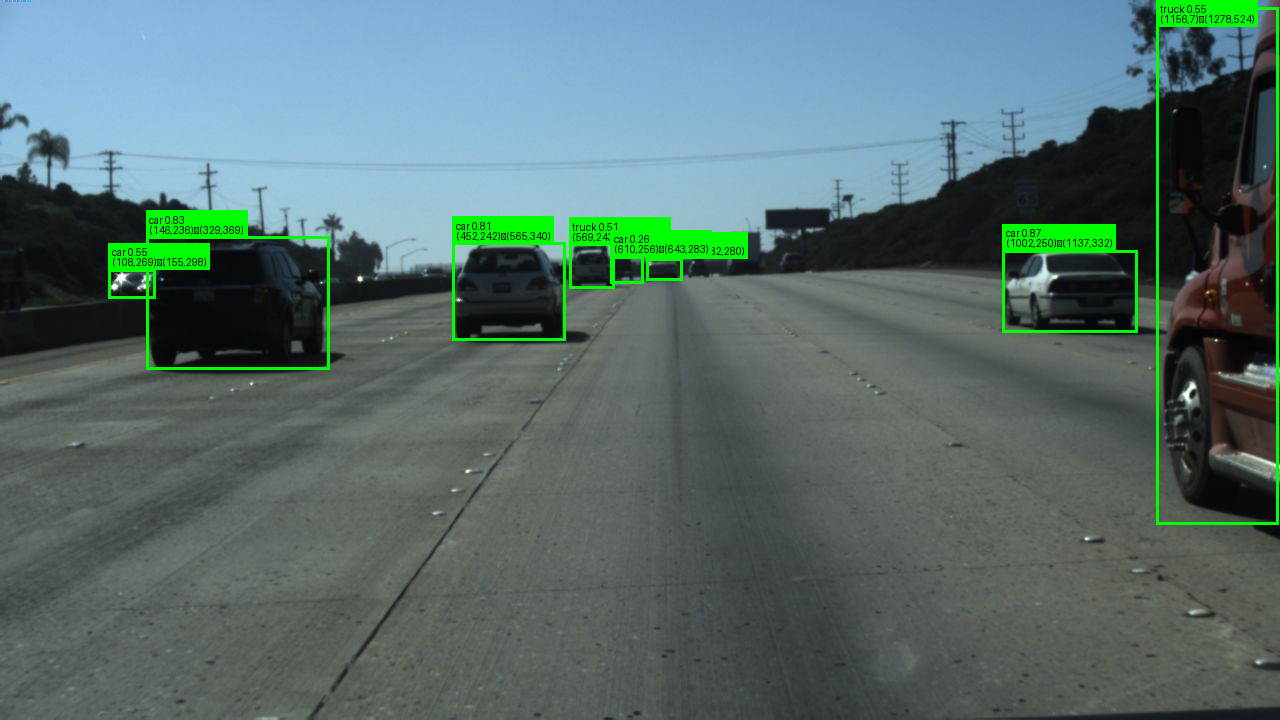

In [31]:
DATASET_ROOT = r"Z:\EE_297A\dataset\lanes\TUSimple\train_set"  # folder that contains 'clips'
show_yolo_on_df_index(
    df=df_json,
    idx=0,                 # change this index to test any frame
    dataset_root=DATASET_ROOT,
    vehicles_only=True,    # set False to draw all COCO classes
    save=False
)